#### General imports and definitions

In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import joblib
import shutil
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.utils import class_weight

import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.4
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-19 10:16:15.254443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 10:16:15.334750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 10:16:15.335640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Suppress warnings

In [2]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Set seed for reproducibility

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Load and clean the dataset

In [4]:
# Load the .npy file
X = np.load(r'../input/training/x_train.npy').astype(np.float32)
y = np.load(r'../input/training/y_train.npy').astype(np.int8)

# Leave a copy of numerical y
y_num = np.copy(y)

# Note as sequences are already built, with window 36
print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float32
(2429,), int8


#### Drop features

In [5]:
def keep_only(X, features_list):
    n_instances, n_timestamps, n_features = X.shape
    X = np.reshape(X, newshape=(-1, n_features))
    temp = np.empty((n_instances * n_timestamps, len(features_list)))
    
    i = 0
    for f in features_list:
        temp[:, i] = X[:, f]
        i += 1
    
    temp = np.reshape(temp, newshape=(n_instances, n_timestamps, len(features_list)))
    return temp

drop = False

if drop:
    X = keep_only(X, [1, 2, 3, 4, 5])
    
print(X.shape)

(2429, 36, 6)


In [6]:
# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y)))
print(class_weights, '\n')

# Convert the sparse labels to categorical values
y = tfk.utils.to_categorical(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

{0: 5.953431372549019, 1: 1.6456639566395663, 2: 0.7496913580246913, 3: 0.5312773403324584, 4: 3.264784946236559, 5: 1.3229847494553377, 6: 0.6466986155484558, 7: 2.9767156862745097, 8: 1.6868055555555554, 9: 0.2605105105105105, 10: 2.628787878787879, 11: 3.968954248366013} 

(1943, 36, 6) (1943, 12)
(486, 36, 6) (486, 12)


#### Metadata

In [7]:
classes = y_train.shape[-1]
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

# For training
batch_size = 2048
epochs = 1000

# Define the scaler we intend to use
scaler = StandardScaler()

# Define the PCA
final_dim = 5
pca = PCA(n_components=final_dim, random_state=42)

# Define the K-fold Cross Validator
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

#### Data scaling

In [8]:
def scale(X_train, X_test, scaler, pca):
    n_instances_train = X_train.shape[0]
    X_train = np.reshape(X_train, newshape=(-1, 6))
    X_train = scaler.fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    X_train = np.reshape(X_train, newshape=(n_instances_train, 36, final_dim))
    
    if X_test is not None:
        n_instances_test = X_test.shape[0]
        X_test = np.reshape(X_test, newshape=(-1, 6))
        X_test = scaler.transform(X_test)
        X_test = pca.transform(X_test)
        X_test = np.reshape(X_test, newshape=(n_instances_test, 36, final_dim))
        return X_train, X_test
    
    return X_train, None

scaling = True

if scaling:
    X_train, X_test = scale(X_train, X_test, scaler, pca)
    
print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)

(1943, 36, 5) float32
(486, 36, 5) float32


In [9]:
input_shape = X_train.shape[1:]
n_timestamps, n_features = input_shape

#### Support functions

In [10]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None)
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

#### Classifier

In [11]:
# we advice to choose what parameters to change and include them directly among the attributes of this function
def build_TS_classifier(input_shape, classes):
    
    input_layer = tfkl.Input(shape=input_shape)
    
    # Convolutional
    x = tfkl.Conv1D(
        filters = 1024,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(input_layer)
    
    x = tfkl.Dropout(0.2, seed=seed)(x)
    
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(
        filters = 1024,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(x)
    
    x = tfkl.Dropout(0.2, seed=seed)(x)
    
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(
        filters = 2048,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(x)
    
    x = tfkl.Dropout(0.2, seed=seed)(x)
    
    #x = tfkl.AveragePooling1D()(x)
    
    # LSTMs
    x = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True))(x)
    
    x = tfkl.Dropout(0.2, seed=seed)(x)
    
    x = tfkl.Bidirectional(tfkl.GRU(32))(x)
    
    x = tfkl.Dropout(0.2, seed=seed)(x)
    
    # Classifier
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='best_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-3), metrics='accuracy')

    # Return the model
    return model

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° START °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Training for fold 1  

2022-12-19 10:16:16.009076: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 10:16:16.009533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 10:16:16.010423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 10:16:16.011097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

==> score: accuracy of 65.844% (elapsed time: 52.555 sec)
-------------------------------------------------------------------------------
Training for fold 2  ==> score: accuracy of 70.782% (elapsed time: 71.160 sec)
-------------------------------------------------------------------------------
Training for fold 3  ==> score: accuracy of 68.724% (elapsed time: 82.364 sec)
-------------------------------------------------------------------------------
Training for fold 4  ==> score: accuracy of 74.486% (elapsed time: 79.449 sec)
-------------------------------------------------------------------------------
Training for fold 5  ==> score: accuracy of 73.251% (elapsed time: 70.584 sec)
-------------------------------------------------------------------------------
Training for fold 6  ==> score: accuracy of 76.955% (elapsed time: 94.116 sec)
-------------------------------------------------------------------------------
Training for fold 7  ==> score: accuracy of 68.313% (elapsed time: 

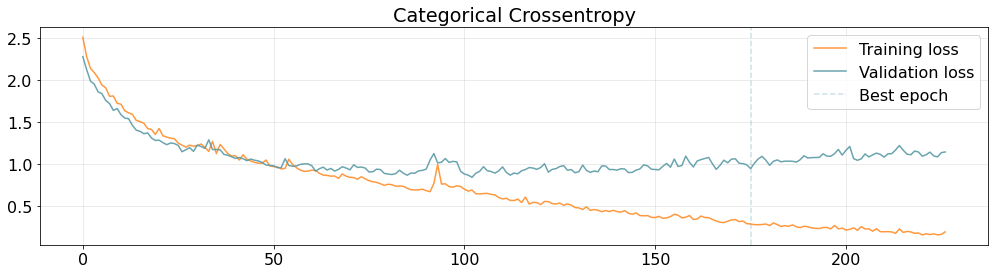

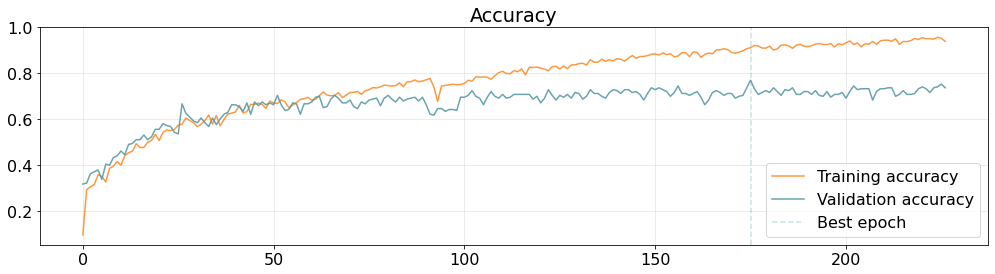

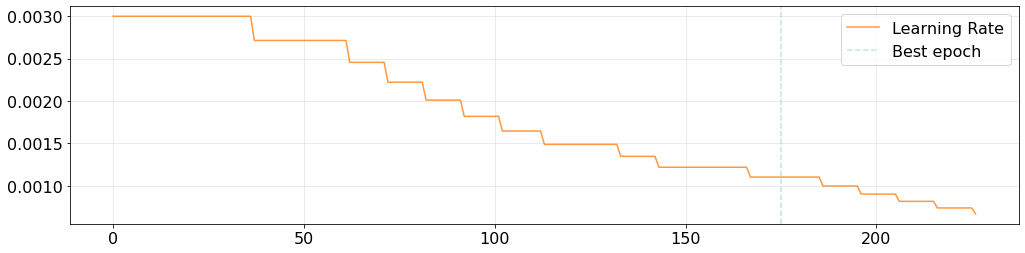

In [12]:
cross_val = True
final_train = False

if cross_val:
    best_acc = 0
    best_model = None
    best_scaler = None
    best_pca = None
    best_history =  []
    
    # grid search FORs go here (remember to indent the following code: SEE THEN)
    #print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° MODEL {i} °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
    
    print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° START °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')

    acc_per_fold = []
    fold_no = 1
    for train, test in kfold.split(X, y_num):
        print(f'Training for fold {fold_no} ', end=' ')

        # Intantiate a new model
        model = build_TS_classifier(input_shape, classes)
        
        # Define targets
        y_train = np.copy(y[train])
        y_test = np.copy(y[test])
        
        # Apply scaling
        X_train, X_test = scale(np.copy(X[train]), np.copy(X[test]), scaler, pca)
        
        start = time.time()
        history = model.fit(X_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_data = (X_test, y_test),
                  #class_weight = class_weights,
                  verbose = 0,
                  callbacks = [
                      tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=51, restore_best_weights=True),
                      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=tf.math.exp(-0.1), min_lr=2e-5)
                  ]
        ).history
        end = time.time()

        # Generate generalization metrics
        acc = np.max(history['val_accuracy']) * 100
        print(f'==> score: accuracy of {acc:.3f}% (elapsed time: {(end - start):.3f} sec)')
        acc_per_fold.append(acc)
        if not final_train and acc > best_acc:
            best_acc = acc
            best_model = model
            best_history = history
            best_scaler = scaler
            best_pca = pca

        # Increase fold number
        fold_no = fold_no + 1
        print('-------------------------------------------------------------------------------')

    print('\nAverage scores for all folds:')
    acc = np.mean(acc_per_fold)
    print(f'> Accuracy: {acc:.3f}% (+- {np.std(acc_per_fold):.3f}%)')
    if final_train and acc > best_acc:
            best_acc = acc
            best_model = model
            best_history = history
    
    # INDENT TILL THE PREVIOUS LINE
    print('°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
              
    # Plot results
    best_model.summary()
    plot_history(best_history)

    # Retrain the best model on the whole dataset
    if final_train:
        
        # Reinstanciate the model (if we have parameters we must pass them over)
        best_model = build_TS_classifier(input_shape, classes)
        
        # Apply scaling
        X, _ = scale(X, None, scaler, pca)
        
        best_model.fit(
            x = X,
            y = y,
            batch_size = batch_size,
            epochs = epochs,
            #class_weight = class_weights,
            callbacks = [
                tfk.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=81, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor='accuracy', mode='max', patience=10, factor=tf.math.exp(-0.1), min_lr=2e-5)
            ]
        )
    
else:
    
    best_model = build_TS_classifier(input_shape, classes)
    best_model.summary()
    
    # Train the model
    best_history = best_model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_test, y_test),
        #class_weight = class_weights,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=81, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=tf.math.exp(-0.1), min_lr=2e-5)
        ]
    ).history

    # Plot results
    plot_history(best_history)
    plot_cm(best_model)

#### Save the scalers

In [13]:
# Needed to write correct preprocessing code: returns the scalers fit on the whole dataset only if 
# the "final_train" flag is set, otherwise returns the ones fit on the best fold
if not final_train:
    scaler = best_scaler
    pca = best_pca
    
if "scalers" not in os.listdir():
    os.mkdir("scalers")
    
scaler_filename = "scalers/scaler.save"
joblib.dump(scaler, scaler_filename) 
pca_filename = "scalers/pca.save"
joblib.dump(pca, pca_filename) 

shutil.make_archive('scalers', 'zip', 'scalers')

'/kaggle/working/scalers.zip'

#### Save the model

In [14]:
best_model.save('best_model')

shutil.make_archive('best_model', 'zip', 'best_model')

2022-12-19 10:31:42.985233: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


'/kaggle/working/best_model.zip'